In [1]:
from pathlib import Path
import torch
import numpy as np
import random
from data import sample_latents
from vis import *
from models import *

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [2]:
D = [5, 5]
M = [[64, 64, 3], [64, 64, 3]]
grid_size = 11

z = sample_latents(D, "random_gap", n_samples=10000, gaps=[(0, 0.35, 1), (5, 0, 0.65)])
z = scale_latents(z)

phi = ParallelSlots([SpriteworldRenderer(d_in, d_out) for d_in, d_out in zip(D, M)])
C = Add()
f = CompositionalFunction(C, phi).to(dev)
f.eval()

with torch.no_grad():
    x, slots = f(z.to(dev), return_slot_outputs=True)

In [ ]:
visualize_latents(z, D, grid_size)

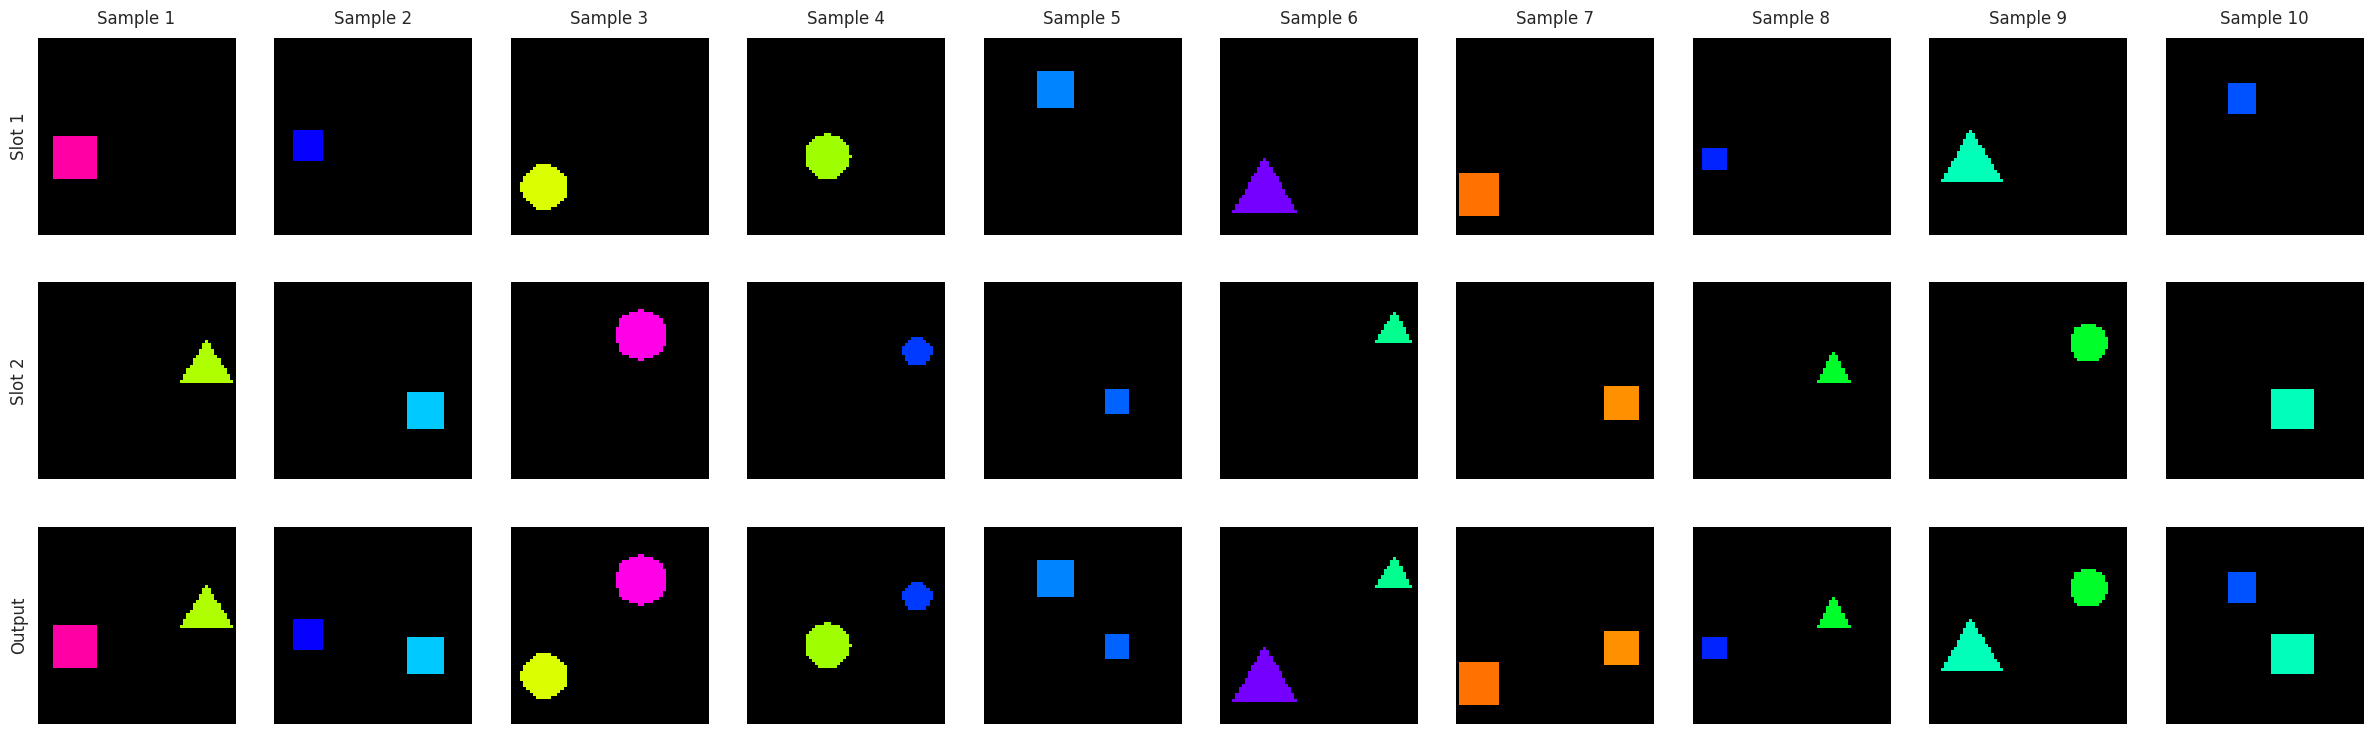

In [3]:
visualize_slots_and_output(x[:10], slots[:10])

In [4]:
visualize_output_grid(f, plot_size=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

/tmp/ipykernel_27405/2979517920.py:10: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array([get_bbox(ax) for ax in axs.flat], mtrans.Bbox).reshape(axs.shape)


[1, 0.7887500000000001, 0.5962500000000002, 0.40375000000000005, 0.21125000000000005, 0]
1 0
0.7887500000000001 0
0.21976562499999996 -0.1924999999999999
2 1
0.5962500000000002 0.21976562499999996
0.19437500000000008 -0.19250000000000012
3 0
0.40375000000000005 0
0.21976562499999996 -0.1925
3 2
0.40375000000000005 0.41414062500000004
0.19437500000000008 -0.1925
4 1
0.21125000000000005 0.21976562499999996
0.19437500000000008 -0.21125000000000005
4 3
0.21125000000000005 0.6085156250000001
0.19437500000000008 -0.21125000000000005


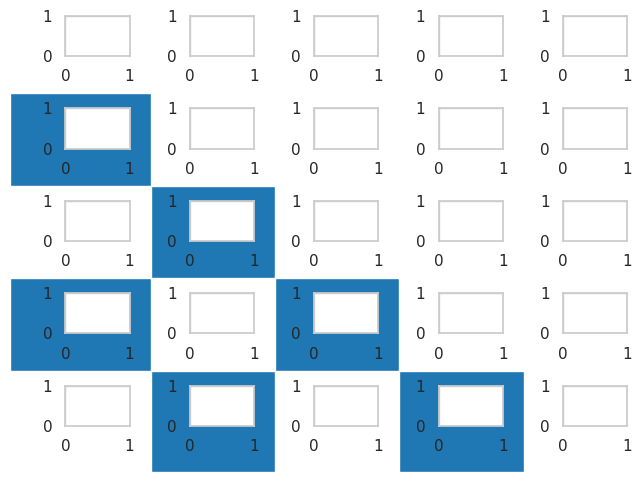

In [38]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.patches as patches
import numpy as np

def _get_xy_between_plots(fig, axs):
    # get bounding boxes
    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    bboxes = np.array([get_bbox(ax) for ax in axs.flat], mtrans.Bbox).reshape(axs.shape)

    # get min/max extent and coordinates between them
    xmax = np.array([b.x1 for b in bboxes.flat]).reshape(axs.shape).max(axis=0)
    xmin = np.array([b.x0 for b in bboxes.flat]).reshape(axs.shape).min(axis=0)
    ymax = np.array([b.y1 for b in bboxes.flat]).reshape(axs.shape).max(axis=1)
    ymin = np.array([b.y0 for b in bboxes.flat]).reshape(axs.shape).min(axis=1)
    xs = np.c_[xmax[1:], xmin[:-1]].mean(axis=1)
    ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)
    return xs, ys

fig, axs = plt.subplots(5, 5)
plt.tight_layout()
xs, ys = _get_xy_between_plots(fig, axs)
# for x, y in zip(xs, ys):
#     print(x, y)
#     # horizontal divider
#     line = plt.Line2D([0,x],[y,y], transform=fig.transFigure, color="red")
#     fig.add_artist(line)
#     # vertical divider
#     line = plt.Line2D([x,x],[0,y], transform=fig.transFigure, color="red")
#     fig.add_artist(line)
xs, ys = [0] + list(xs) + [1], [1] + list(ys) + [0]
print(ys)
for row in range(5):
    for col in range(row):
        if (row + col) % 2 == 1:
            w = xs[col + 1] - xs[col]
            h = ys[row + 1] - ys[row]
            # axs[row, col].patch.set_facecolor("red")
            print(row, col)
            print(ys[row], xs[col])
            print(w, h)
            patch = patches.Rectangle((xs[col], ys[row]), w, h, edgecolor=None, facecolor="tab:blue", transform=fig.transFigure, zorder=0)
            fig.add_artist(patch)

In [13]:
xs + [0]

array([1.2121582, 1.4074707, 1.6027832, 1.7980957])

In [12]:
checkpoint = Path("/home/thaddaus/code/cood/_checkpoints/ADD_ortho_20230411-140849/latest.pt")

phi_hat = ParallelSlots(
        [
            MLP(d_in, d_out, d_hidden=10)
            for d_in, d_out in zip(D, M)
        ]
    )
f_hat = CompositionalFunction(C, phi_hat)
f_hat.to(dev)

f_hat.load_state_dict(torch.load(checkpoint))
f_hat.eval()

with torch.no_grad():
    x_hat = f_hat(z.to(dev)).to("cpu")

err = (x_hat - x).pow(2).mean(dim=-1)

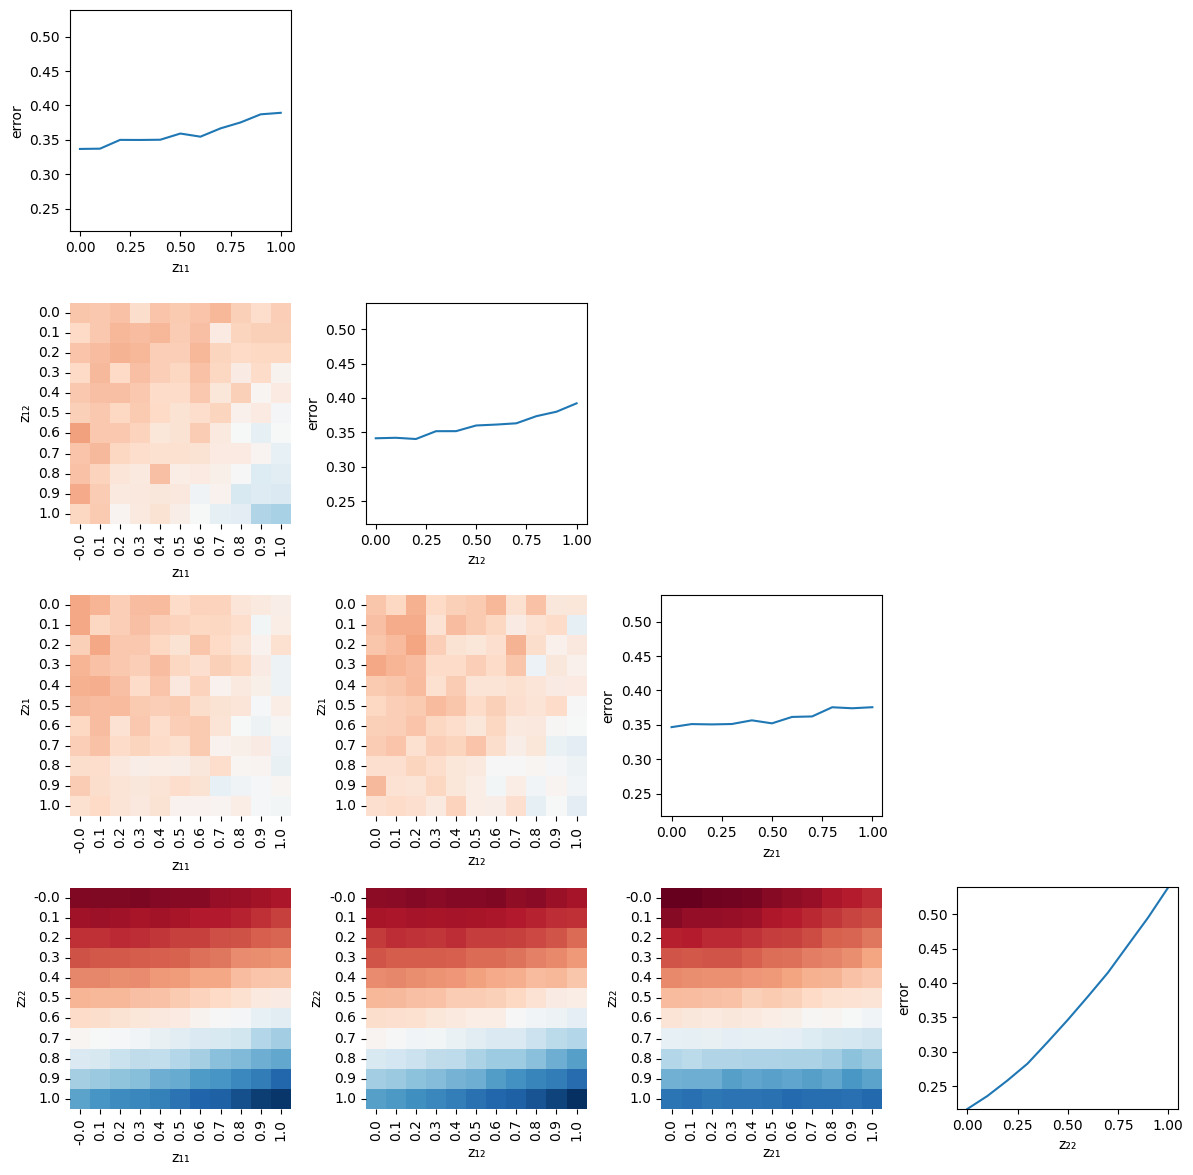

In [13]:
visualize_score_heatmaps(z, err, D, "error")